In [18]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')
import numpy as np
import pandas as pd
from base import BaseModel
from stats import loglikelihood_normal
from datetime import timedelta, datetime
from monthdelta import monthdelta
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
class EWMA(BaseModel):
    def __init__(self, plot = True, lam = 0.94, *args):
        self.plot = plot
        self.lam = 0.94
        self.args = args
    
    def initialize_params(self, y):
        self.init_params = np.array([self.lam])
        return self.init_params
    
    def model_filter(self, params, y):
        T = y.shape[0]
        sigma2 = np.zeros(T)
        lamb = params
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * y[t - 1] ** 2
        return sigma2
    
    def loglikelihood(self, params, y):
        sigma2 = self.model_filter(params, y)
        return loglikelihood_normal(y, sigma2)
    
    def simulate(self, lamb, T):
        sigma2 = np.zeros(T)
        ret = np.zeros(T)
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * ret[t - 1] ** 2
            ret[t] = np.random.normal(scale = np.sqrt(sigma2[t]))
            
        return ret, sigma2
    
class Panel_EWMA(BaseModel):
    def __init__(self, plot = True, lam = 0.94, *args):
        self.plot = plot
        self.lam = 0.94
        self.args = args
    
    def initialize_params(self, y):
        self.init_params = np.array([self.lam])
        return self.init_params
    
    def model_filter(self, params, y):
        T = y.shape[0]
        sigma2 = np.zeros(T)
        lamb = params
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * y[t - 1] ** 2
        return sigma2
    
    def loglikelihood(self, params, y):
        lls = 0
        
        for i in range(y.shape[1]):
            idx = np.where(np.isnan(y.iloc[:, i]) == False)[0]
            sig = self.model_filter(params, y.iloc[idx, i].values)
            if len(sig) == 0:
                lls += 0
            else:
                lls += loglikelihood_normal(y.iloc[idx, i].values, sig)
        return lls
    
    def forecast(self, y):
        row_nul = pd.DataFrame([[0]*y.shape[1]], columns = y.columns)
        y = y.append(row_nul)
        forecast = np.zeros(len(y.columns))
        for i in range(ret_mat.shape[1]):
            idx = np.where(np.isnan(y.iloc[:, i]) == False)[0]
            if len(idx) == 0:
                forecast[i] = np.nan
            else:
                sig = model.model_filter(model.optimized_params, y.iloc[idx, i].values)
                forecast[i] = sig[-1]
        return forecast
    
    def simulate(self, lamb = 0.94, T = 500, num = 100):
        sigma2 = np.zeros((T, num))
        r = np.zeros((T, num))
        
        for t in range(T):
            if t == 0:
                sigma2[t] = 1.0
            else:
                sigma2[t] = lamb * sigma2[t - 1] + (1 - lamb) * r[t - 1] ** 2
            r[t] = np.random.normal(0.0, np.sqrt(sigma2[t]), size = num)
        return r, sigma2

In [3]:
model = EWMA()

In [4]:
y, sigma2 = model.simulate(lamb = 0.94, T = 1000)

In [5]:
model.fit(['01'], y)

Loglikelihood:  2.961224274440281 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941994        0.006382      0.929485       0.954502


In [10]:
def create_sim(num_of_sim = 500, length = 1000, param = 0.94, plot = False):
    lamb = np.zeros(num_of_sim)
    
    model = EWMA(plot = plot)
    for t in range(num_of_sim):
        y, _ = model.simulate(lamb = param, T = length)
        model.fit(['01'], y)
        lamb[t] = model.optimized_params
    return pd.DataFrame(data = lamb)

In [11]:
sim1 = create_sim(length=500)

In [12]:
sim2 = create_sim()

In [13]:
sim3 = create_sim(length = 2000)

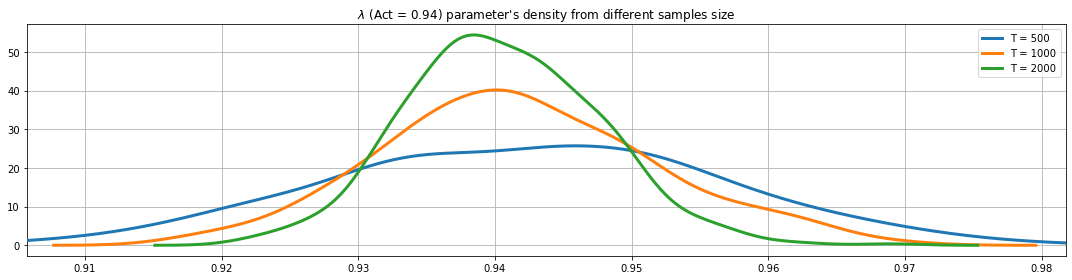

In [21]:
lamb1 = sm.nonparametric.KDEUnivariate(sim1.values)
lamb1.fit()
lamb2 = sm.nonparametric.KDEUnivariate(sim2.values)
lamb2.fit()
lamb3 = sm.nonparametric.KDEUnivariate(sim3.values)
lamb3.fit()

fig , ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)

ax.plot(lamb1.support, lamb1.density, lw = 3, label = 'T = 500', zorder = 10)
ax.plot(lamb2.support, lamb2.density, lw = 3, label = 'T = 1000', zorder = 10)
ax.plot(lamb3.support, lamb3.density, lw = 3, label = 'T = 2000', zorder = 10)
ax.set_title(r'$\lambda$'+" (Act = 0.94) parameter's density from different samples size")
ax.grid(True, zorder = -5)
ax.set_xlim((np.min(sim1.values), np.max(sim1.values)))
ax.legend(loc = 'best')

plt.show()

In [26]:
model = Panel_EWMA()

In [27]:
y, _ = model.simulate()

In [30]:
model.fit(['01'], pd.DataFrame(y))

Loglikelihood:  98.71752304554362 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938292        0.005062      0.928371       0.948212


In [31]:
def create_sim(num_of_sim = 500, length = 1000, param = 0.94, num_of_asset = 100, plot = False):
    lamb = np.zeros(num_of_sim)
    
    model = Panel_EWMA(plot = plot)
    for t in range(num_of_sim):
        y, _ = model.simulate(lamb = param, T = length, num = num_of_asset)
        model.fit(['01'], pd.DataFrame(y))
        lamb[t] = model.optimized_params
    return pd.DataFrame(data = lamb)

In [34]:
sim11 = create_sim(plot = True)

Loglikelihood:  51.68458848942951 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937826        0.003442       0.93108       0.944572
Loglikelihood:  55.311981360214894 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939401         0.00355      0.932443       0.946358
Loglikelihood:  63.98626312517135 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941038        0.003555       0.93407       0.948005
Loglikelihood:  60.07792453721989 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939839        0.003547      0.932886       0.946791
Loglikelihood:  76.50565649211471 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938468        0.003606      0.931401       0.945535
Loglikelihood:  61.26641809453579 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938899        0.003575      0.931891       0.945906
Loglikelihood:  59.27347705809731 

   Parameters  Standard Error  95% CI L

Loglikelihood:  69.80066685871456 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940601        0.003651      0.933446       0.947756
Loglikelihood:  64.2042814798926 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939178        0.003462      0.932394       0.945963
Loglikelihood:  66.83557618618909 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939667        0.003583      0.932643        0.94669
Loglikelihood:  73.78747376692512 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93917         0.00357      0.932173       0.946166
Loglikelihood:  66.50720877286511 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941075        0.003595      0.934028       0.948121
Loglikelihood:  52.45332898993138 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93918        0.003504      0.932312       0.946049
Loglikelihood:  42.37060424492402 

   Parameters  Standard Error  95% CI Low

Loglikelihood:  67.95958139059603 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940429        0.003601      0.933371       0.947487
Loglikelihood:  60.085019786721666 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942814        0.003648      0.935663       0.949965
Loglikelihood:  65.23241264698062 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939629        0.003596      0.932581       0.946678
Loglikelihood:  63.94676874173556 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939735        0.003602      0.932675       0.946795
Loglikelihood:  60.5402492578945 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941644        0.003582      0.934623       0.948664
Loglikelihood:  58.41743757077607 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941131        0.003588      0.934099       0.948162
Loglikelihood:  65.7503105083229 

   Parameters  Standard Error  95% CI Low

Loglikelihood:  66.69185415230176 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939064        0.003607      0.931994       0.946133
Loglikelihood:  62.29907711940904 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939896        0.003603      0.932833       0.946959
Loglikelihood:  59.11741865530838 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940839         0.00357      0.933842       0.947836
Loglikelihood:  62.774974894057955 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940636        0.003557      0.933665       0.947607
Loglikelihood:  54.4106861887771 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939741        0.003502      0.932878       0.946605
Loglikelihood:  63.31793164708138 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940788         0.00364      0.933654       0.947921
Loglikelihood:  68.36260212345277 

   Parameters  Standard Error  95% CI Lo

Loglikelihood:  61.8939265073221 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940562        0.003544      0.933616       0.947508
Loglikelihood:  60.85936318264806 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939935        0.003595       0.93289        0.94698
Loglikelihood:  65.79334939047682 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939935        0.003615       0.93285       0.947019
Loglikelihood:  51.71363708037928 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938873        0.003514      0.931985        0.94576
Loglikelihood:  61.38474950449015 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939413        0.003578      0.932401       0.946425
Loglikelihood:  72.58622533964994 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940038        0.003637       0.93291       0.947166
Loglikelihood:  64.94754409804266 

   Parameters  Standard Error  95% CI Low

Loglikelihood:  66.75083902301716 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940589        0.003592      0.933549       0.947628
Loglikelihood:  62.07529479945417 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942607        0.003648      0.935456       0.949758
Loglikelihood:  62.125890146862 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940416        0.003538      0.933482        0.94735
Loglikelihood:  59.96221388369687 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939722        0.003503      0.932857       0.946587
Loglikelihood:  55.26470686296925 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941339        0.003583      0.934316       0.948362
Loglikelihood:  56.161457405565386 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94087        0.003655      0.933707       0.948034
Loglikelihood:  70.52931878519716 

   Parameters  Standard Error  95% CI Low

Loglikelihood:  55.738931445122546 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938773        0.003524      0.931866       0.945681
Loglikelihood:  63.290583391830864 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939616        0.003548      0.932663       0.946569
Loglikelihood:  61.441936701036795 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939963         0.00359      0.932926          0.947
Loglikelihood:  54.278478346115335 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940157        0.003571      0.933159       0.947156
Loglikelihood:  61.3389684191999 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94104         0.00354      0.934101       0.947979
Loglikelihood:  70.09430659503447 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940652        0.003609      0.933579       0.947726
Loglikelihood:  70.45624107088707 

   Parameters  Standard Error  95% CI

Loglikelihood:  64.05131519645616 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940369        0.003598      0.933317       0.947421
Loglikelihood:  62.46125192855346 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94115        0.003624      0.934046       0.948253
Loglikelihood:  53.64983353107387 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939982        0.003578       0.93297       0.946995
Loglikelihood:  69.19916081641735 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940118        0.003557      0.933146       0.947089
Loglikelihood:  50.015405721645145 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940144        0.003596      0.933096       0.947192
Loglikelihood:  70.65651866005926 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941315         0.00356      0.934338       0.948292
Loglikelihood:  69.24273353374595 

   Parameters  Standard Error  95% CI L

Loglikelihood:  63.81414283760334 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940092        0.003574      0.933088       0.947096
Loglikelihood:  62.12755977471591 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940519        0.003621      0.933422       0.947616
Loglikelihood:  70.7189367962706 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940741        0.003599      0.933687       0.947794
Loglikelihood:  76.46610710610264 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939956        0.003699      0.932707       0.947206
Loglikelihood:  50.89831155400589 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940089        0.003549      0.933132       0.947046
Loglikelihood:  64.60189451299865 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939134        0.003581      0.932115       0.946153
Loglikelihood:  53.71437999668791 

   Parameters  Standard Error  95% CI Low

Loglikelihood:  64.57182754999295 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940027        0.003506      0.933155         0.9469
Loglikelihood:  63.20244566252286 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93966        0.003574      0.932655       0.946666
Loglikelihood:  67.60476958306027 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941342        0.003678      0.934133       0.948551
Loglikelihood:  59.346595358623226 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939927        0.003654      0.932765       0.947089
Loglikelihood:  61.80450426744903 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939595        0.003577      0.932585       0.946605
Loglikelihood:  74.30294707427984 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940058        0.003585      0.933031       0.947085
Loglikelihood:  70.93666501388195 

   Parameters  Standard Error  95% CI L

In [37]:
sim22 = create_sim(num_of_asset = 50, plot = True)

Loglikelihood:  38.866479526989856 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.93979        0.005268      0.929465       0.950115
Loglikelihood:  28.676564186528296 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937765         0.00496      0.928044       0.947487
Loglikelihood:  29.324556106171983 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938593        0.005036      0.928723       0.948463
Loglikelihood:  31.629913093841218 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938802        0.005023      0.928957       0.948646
Loglikelihood:  31.67497660555971 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940037        0.005156      0.929931       0.950143
Loglikelihood:  30.17018469238263 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942961        0.005206      0.932757       0.953166
Loglikelihood:  30.733749937086433 

   Parameters  Standard Error  95% 

Loglikelihood:  33.55255618174929 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939413        0.005024      0.929566       0.949259
Loglikelihood:  28.296668052945513 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939452        0.005081      0.929493       0.949411
Loglikelihood:  29.11179043828027 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938346        0.005003      0.928541       0.948152
Loglikelihood:  27.996968154021225 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940719        0.005088      0.930748       0.950691
Loglikelihood:  36.04531938816883 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941159        0.005133      0.931098       0.951219
Loglikelihood:  27.500323134135616 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941526        0.005069       0.93159       0.951462
Loglikelihood:  33.040509819494886 

   Parameters  Standard Error  95% C

Loglikelihood:  17.71290267302817 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938013        0.004858      0.928492       0.947535
Loglikelihood:  30.815846068549842 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940452        0.005129        0.9304       0.950504
Loglikelihood:  30.335572432732242 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941063        0.005027      0.931211       0.950915
Loglikelihood:  43.4675717571789 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939116         0.00506      0.929199       0.949034
Loglikelihood:  27.2816424449221 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939901        0.005078      0.929949       0.949853
Loglikelihood:  26.175812066467618 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939758        0.005016      0.929927        0.94959
Loglikelihood:  34.229168534588446 

   Parameters  Standard Error  95% CI 

Loglikelihood:  19.369337566602027 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938197        0.004923      0.928548       0.947847
Loglikelihood:  22.000984128236443 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937696        0.004887      0.928119       0.947273
Loglikelihood:  37.735523212296094 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941285         0.00529      0.930916       0.951653
Loglikelihood:  36.97307568454985 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941882        0.005153      0.931783       0.951982
Loglikelihood:  18.578849166295768 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938495        0.004846      0.928998       0.947993
Loglikelihood:  20.686113101404963 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937197        0.004784      0.927821       0.946573
Loglikelihood:  23.08341454235396 

   Parameters  Standard Error  95% 

Loglikelihood:  35.18396095665211 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938391        0.005079      0.928436       0.948346
Loglikelihood:  28.377030890927823 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940341        0.005102      0.930342        0.95034
Loglikelihood:  28.294958439513316 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941348        0.005032      0.931485        0.95121
Loglikelihood:  39.588556883403854 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942126        0.005128      0.932076       0.952177
Loglikelihood:  27.197030063797584 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940073        0.005093      0.930091       0.950055
Loglikelihood:  31.06184039785505 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940702        0.004973      0.930954        0.95045
Loglikelihood:  32.22428118755105 

   Parameters  Standard Error  95% C

Loglikelihood:  24.306639345532766 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939103        0.005001        0.9293       0.948906
Loglikelihood:  27.394797583115025 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938723        0.004893      0.929132       0.948314
Loglikelihood:  34.13407746406856 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940356        0.005077      0.930404       0.950307
Loglikelihood:  31.26596540482055 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938853        0.004982      0.929088       0.948618
Loglikelihood:  37.01717978651087 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940256        0.005033      0.930391       0.950121
Loglikelihood:  36.25845227335802 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940907        0.005178      0.930758       0.951057
Loglikelihood:  28.654629412855765 

   Parameters  Standard Error  95% CI

Loglikelihood:  38.29657342920064 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941656        0.005153      0.931556       0.951756
Loglikelihood:  43.89604739190367 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942492         0.00523      0.932242       0.952743
Loglikelihood:  31.009075370799952 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941622        0.005113      0.931601       0.951643
Loglikelihood:  31.038145303533355 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940005        0.006388      0.927486       0.952525
Loglikelihood:  25.637433631646427 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94002        0.005049      0.930123       0.949916
Loglikelihood:  22.070066744713404 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937796        0.004945      0.928104       0.947488
Loglikelihood:  20.167106494809953 

   Parameters  Standard Error  95% 

Loglikelihood:  36.51490789983461 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939967        0.005058      0.930053        0.94988
Loglikelihood:  26.30776210366879 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938137        0.004965      0.928405       0.947869
Loglikelihood:  22.74810941755699 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938516        0.004763      0.929181        0.94785
Loglikelihood:  38.777410421875615 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94153        0.005162      0.931412       0.951649
Loglikelihood:  28.770589553639244 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.942152        0.005166      0.932026       0.952278
Loglikelihood:  39.78529095092538 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941085        0.005031      0.931225       0.950945
Loglikelihood:  31.568478881653984 

   Parameters  Standard Error  95% CI

Loglikelihood:  29.3617399649545 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938652        0.004989      0.928875        0.94843
Loglikelihood:  30.734376446995938 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937418        0.004927      0.927761       0.947074
Loglikelihood:  25.474720170211445 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.940224        0.005112      0.930205       0.950243
Loglikelihood:  26.4987954262674 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.936814        0.004968      0.927076       0.946552
Loglikelihood:  25.647530035225433 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939872        0.004956      0.930158       0.949586
Loglikelihood:  25.19628856307963 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937536        0.004963      0.927808       0.947264
Loglikelihood:  34.99515825850886 

   Parameters  Standard Error  95% CI L

Loglikelihood:  38.68602515644569 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.937738        0.005125      0.927694       0.947783
Loglikelihood:  32.73430858820253 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0     0.94254        0.005162      0.932422       0.952658
Loglikelihood:  28.307249796540844 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939008        0.004995      0.929218       0.948799
Loglikelihood:  35.59516890200493 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.941258        0.004989       0.93148       0.951036
Loglikelihood:  31.143465929965956 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.939161         0.00507      0.929223       0.949099
Loglikelihood:  32.24517614684875 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.938747        0.004993      0.928962       0.948532
Loglikelihood:  21.642259646589583 

   Parameters  Standard Error  95% CI

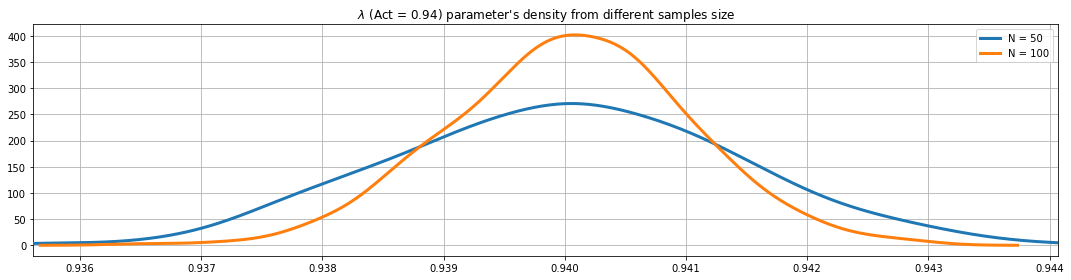

In [38]:
lamb1 = sm.nonparametric.KDEUnivariate(sim11.values)
lamb1.fit()
lamb2 = sm.nonparametric.KDEUnivariate(sim22.values)
lamb2.fit()

fig , ax = plt.subplots(1, 1, figsize=(15, 4), tight_layout=True)

ax.plot(lamb2.support, lamb2.density, lw = 3, label = 'N = 50', zorder = 10)
ax.plot(lamb1.support, lamb1.density, lw = 3, label = 'N = 100', zorder = 10)
ax.set_title(r'$\lambda$'+" (Act = 0.94) parameter's density from different samples size")
ax.grid(True, zorder = -5)
ax.set_xlim((np.min(sim22.values), np.max(sim22.values)))
ax.legend(loc = 'best')

plt.show()

In [20]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:] * 100

ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]

if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

ret_mat.pop('AMCR')

Date
1999-11-19         NaN
1999-11-22         NaN
1999-11-23         NaN
1999-11-24         NaN
1999-11-26         NaN
                ...   
2020-10-26   -0.031484
2020-10-27   -0.005660
2020-10-28   -0.023936
2020-10-29    0.017292
2020-10-30   -0.006689
Name: AMCR, Length: 5270, dtype: float64

In [21]:
y = ret_mat[(ret_mat.index >= datetime(1999,12,1)) & (ret_mat.index < datetime(2005, 1, 1))]

In [22]:
model = Panel_EWMA()

In [24]:
model.fit(['01'], y)

Loglikelihood:  945.2677241498297 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.952133        0.001385      0.949418       0.954848
